# <center> *mocalum* tutorial 4 <br><br> Monte-Carlo simulation for single-Doppler configuration <center>

A notebook by Nikola Vasiljević
    
## Introduction

In this section we will calculate wind speed uncertainty of a single-Doppler setup by means of Monte-Carlo simulations. We will consider a sector-scanning lidar performing a PPI scan. The size of the PPI scan and wind direction we will vary. Nevertheless, the range, and thus  elevation angle of the PPI scan, as well the central azimuth angle will be kept fixed.

We will consider two cases in which the uncertainties are correlated or uncorrelated from one to another line of sight (LOS) of the PPI scan respectively. The obtained results will be collected and presented as plots which will show dependency of the wind speed uncertainty with respect to the size of the scanned sector, wind direction and correlation coefficient. The range, and thus elevation angle of the PPI scan will be kept fixed.

    
If you want directly to explore earlier derives results of the Monte-Carlo simulations first import required libraries in the cell below and then go to the notebook section [Results of Monte Carlo simulations](#monte_carlo_results).

In [35]:
import numpy as np           
import matplotlib.pyplot as plt
import xarray as xr
import mocalum as mc

from mocalum_tutorial import plot_sd_scan_setup, plot_bbox, plot_ffield, average_sonic


# setup of fontsize for plots

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [36]:
mc_IVAP = mc.Mocalum()

## Case 1: Uncorrelated uncertainties

Lets consider a lidar which we will call 'koshava', located at position of (0,0,0) having following values for uncertainty contributors (standard uncertainty):
- estimation uncertainty of radial velocity of 0.1 m/s 
- ranging uncertainty of 5 m
- azimuth uncertainty of 0.1 deg
- elevation uncertainty of 0.1 deg
We will consider that uncertainty values are not correlated from one LOS to another, thus correlation coeficient will be equal to 0:

In [37]:
lidar_pos = np.array([0,0,0])

unc_cfg = {'unc_az'   : 0.1,
           'unc_el'   : 0.1,
           'unc_rng'  : 5,
           'unc_est'  : 0.1,
           'corr_coef':0}

mc_IVAP.add_lidar('koshava', lidar_pos, unc_cfg)

Now we will prepare bundle up `mocalum` configurations, which will be execute in `for loop`. For simplicity, we will omit kinematic limits in these configurations. We will generate `turbulent` flow field. To calculate the uncertainty of the reconstructed wind speed we need first to calculate the difference between the actual and reconstructed wind speed. Afterwards we compute the mean difference (which represent the systematic part of the wind speed uncertainty) and standard deviation of the difference (which represents the random part of the wind speed uncertainty).

If we have generated `uniform` flow field this is rather straightforward since the actual wind speed does not change with time. On the other hand, in case of `turbulent` flow fields the wind speed varies with time, thus we need to extract wind speed at specific time instances. `mocalum` provides method called `generate_virtual_sonic` to perform this type of work. This method takes following parameters:

 - `meas_pts` : Measurement points position as (n,3) shaped numpy array
 - `time_steps` : Numpy array of time instances at which sonic is 'measuring'
 
 > **mocalum note**: Beware that `meas_pts` must contain points which are within the bounding box of lidar measurement points. Otherwise the method `generate_virtual_sonic`  will return `NaNs`.
 
In this tutorial we will set `meas_pts` to the central point of the PPI scan, while `time_steps` will be take values of `data.probing[lidar_id].time`. 
 
The result of this method is an `xarray` dataset `data.sonic_wind` containing the wind vector values at given point(s) and given time instances. Since we are going to average PPI scans prior the wind speed reconstruction a function `average_sonic` is provided, which takes the following input parameters: 
 - `ds` : `mocalum` sonic_wind xr dataset
 - `no_samples` : number of samples in averaging block
 and return the averaged sonic_wind xr dataset.
 
We will have to be careful to match `no_samples`, such that the averaged sonic_wind dataset has length matching to the lenght of the reconstructed wind dataset.
 

Before we bundle this all together lets remind ourselves what are the steps in configuration:

In [38]:
meas_range = 1000 # in m
meas_height = 100 # in m
sector_size = 30 # in deg
wind_from_direction = 45 # in deg
avg_period = 600 # in seconds

PPI_cfg = {
    'no_scans' : 2*3*5*7*9*100, # to be able to average for various combination of sector size
    'range' : 1000,
    'meas_height' : meas_height,
    'elevation' : np.degrees(np.arcsin(meas_height / meas_range)), # to assure measurements at 100 m agl
    'angular_step' : 1,  # degreee
    'acq_time' : 1,      # s
    'azimuth_mid' : 90,  # central azimuth angle
    'sector_size' : sector_size,  # degree
}

# calculating number of scans and sonic samples in averaging block
lidar_scans_per_blck = int(avg_period/(sector_size/(PPI_cfg['angular_step'] / PPI_cfg['acq_time'])))
sonic_samples_per_blck = int(avg_period/PPI_cfg['acq_time'])


atmo_cfg={'wind_speed':10,
          'upward_velocity':0,
          'wind_from_direction': wind_from_direction,
          'reference_height':100, # we set the reference height same as the scanned height 
          'shear_exponent':0.2}


mc_IVAP.generate_PPI_scan('koshava', PPI_cfg)
mc_IVAP.generate_uncertainties('koshava')
mc_IVAP.generate_flow_field('koshava', atmo_cfg, 'turbulent')
mc_IVAP.project_to_los('koshava')

# virtual sonic setup/generation
time_steps = mc_IVAP.data.probing['koshava'].time.values
sonic_pos = np.array([[1000,0,meas_height]])
mc_IVAP.generate_virtual_sonic(sonic_pos, time_steps)

# average and reconstruct data
mc_IVAP.reconstruct_wind('koshava', 'IVAP', lidar_scans_per_blck)
avg_sonic_data = average_sonic(mc_IVAP.data.sonic_wind, sonic_samples_per_blck)

# calculate difference:
diff_ds = avg_sonic_data - mc_IVAP.data.rc_wind

# get standard uncertainty 
std_diff_ws = diff_ds.ws.std() # standard uncertainty of horizontal wind speed
std_diff_wdir = diff_ds.wdir.std() # standard uncertainty of wind direction

# get mean difference uncertainty 
mean_diff_ws = diff_ds.ws.mean() # standard uncertainty of horizontal wind speed
mean_diff_wdir = diff_ds.wdir.mean() # standard uncertainty of wind direction


In [43]:
counts, bins = np.histogram(mc_IVAP.data.probing['koshava'].unc_az.values)

In [58]:
mc_IVAP.data.probing['koshava'].unc_az

<xarray.DataArray 'unc_az' (time: 5670000)>
array([ 0.00818395,  0.04879496,  0.00322058, ..., -0.25582913,
       -0.05263019, -0.14784695])
Coordinates:
  * time     (time) float64 1.0 2.0 3.0 4.0 ... 5.67e+06 5.67e+06 5.67e+06
Attributes:
    long_name:      Azimuth uncertainty
    standard_name:  azimuth_uncertainty
    units:          degree
    URI:

Let's now setup loop that will perform Monte Carlo simulations.

We will loop over sector size starting at 10 deg finishing at 90, and run simulations for two wind direciton 0 deg (wind perpendicular to the PPI scan) and 90 deg (wind aligned with the PPI scan).

To know how far we are in simulations we will import package `tqdm` which will display the current progress.

The end result of the simulation will be provided as `xarray` dataset, which will be exported as a [NetCDF](https://en.wikipedia.org/wiki/NetCDF) file for future reuse.

In [11]:
from tqdm.notebook import trange, tqdm

In [12]:
meas_range = 1000 # in m
meas_height = 100 # in m
avg_period = 600 # in seconds

sim_ssize = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sim_wdir = [0,90]

uncertainty = np.empty((len(sim_ssize),
                        len(sim_wdir),2,2))

for i,sector in enumerate(tqdm(sim_ssize, desc ="Sector size loop")):

    sector_size = sector # in deg

    PPI_cfg = {
        'no_scans' : 2*3*5*7*9*100, # to be able to average for various combination of sector size
        'range' : 1000,
        'meas_height' : meas_height,
        'elevation' : np.degrees(np.arcsin(meas_height / meas_range)), # to assure measurements at 100 m agl
        'angular_step' : 1,  # degreee
        'acq_time' : 1,      # s
        'azimuth_mid' : 90,  # central azimuth angle
        'sector_size' : sector_size,  # degree
    }

    # calculating number of scans and sonic samples in averaging block
    lidar_scans_per_blck = int(avg_period/(sector_size/(PPI_cfg['angular_step'] / PPI_cfg['acq_time'])))
    sonic_samples_per_blck = int(avg_period/PPI_cfg['acq_time'])


    for j,wind_from_direction in enumerate(tqdm(sim_wdir, desc ="Wind direction loop", leave = False)):
        atmo_cfg={'wind_speed':10,
                  'upward_velocity':0,
                  'wind_from_direction': wind_from_direction,
                  'reference_height':100, # we set the reference height same as the scanned height 
                  'shear_exponent':0.2}


        mc_IVAP.generate_PPI_scan('koshava', PPI_cfg)
        mc_IVAP.generate_uncertainties('koshava')
        mc_IVAP.generate_flow_field('koshava', atmo_cfg, 'turbulent')
        mc_IVAP.project_to_los('koshava')

        # virtual sonic setup/generation
        time_steps = mc_IVAP.data.probing['koshava'].time.values
        sonic_pos = np.array([[1000,0,meas_height]])
        mc_IVAP.generate_virtual_sonic(sonic_pos, time_steps)

        # average and reconstruct data
        mc_IVAP.reconstruct_wind('koshava', 'IVAP', lidar_scans_per_blck)
        avg_sonic_data = average_sonic(mc_IVAP.data.sonic_wind, sonic_samples_per_blck)

        # calculate difference:
        diff_ds = avg_sonic_data - mc_IVAP.data.rc_wind

        # get random and systematich part of uncertainty
        uncertainty[i,j,0] = np.array([diff_ds.ws.mean(), diff_ds.ws.std()])
        uncertainty[i,j,1] = np.array([diff_ds.wdir.mean(), diff_ds.wdir.std()])           

In [13]:
ds_unc_uncorr = xr.Dataset({'unc_ws': (['corr_coef', 'sector_size', 'wind_direction', 'statistics'], np.array([uncertainty[:,:,0]])),
                            'unc_wdir': (['corr_coef', 'sector_size', 'wind_direction', 'statistics'], np.array([uncertainty[:,:,1]]))},
                           coords={'corr_coef': [0],
                                   'sector_size': sim_ssize,
                                   'wind_direction': sim_wdir,
                                  'statistics': ['mean', 'std']})

## Case 2: Correlated uncertainties

The only difference comparing to the first case is setting up `corr_coef` to 1.

In [16]:
lidar_pos = np.array([0,0,0])

unc_cfg = {'unc_az'   : 0.1,
           'unc_el'   : 0.1,
           'unc_rng'  : 5,
           'unc_est'  : 0.1,
           'corr_coef':1}

mc_IVAP.add_lidar('koshava', lidar_pos, unc_cfg)



meas_range = 1000 # in m
meas_height = 100 # in m
avg_period = 600 # in seconds

sim_ssize = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
sim_wdir = [0,90]

uncertainty = np.empty((len(sim_ssize),
                        len(sim_wdir),2,2))

for i,sector in enumerate(tqdm(sim_ssize, desc ="Sector size loop")):

    sector_size = sector # in deg

    PPI_cfg = {
        'no_scans' : 2*3*5*7*9*100, # to be able to average for various combination of sector size
        'range' : 1000,
        'meas_height' : meas_height,
        'elevation' : np.degrees(np.arcsin(meas_height / meas_range)), # to assure measurements at 100 m agl
        'angular_step' : 1,  # degreee
        'acq_time' : 1,      # s
        'azimuth_mid' : 90,  # central azimuth angle
        'sector_size' : sector_size,  # degree
    }

    # calculating number of scans and sonic samples in averaging block
    lidar_scans_per_blck = int(avg_period/(sector_size/(PPI_cfg['angular_step'] / PPI_cfg['acq_time'])))
    sonic_samples_per_blck = int(avg_period/PPI_cfg['acq_time'])


    for j,wind_from_direction in enumerate(tqdm(sim_wdir, desc ="Wind direction loop", leave = False)):
        atmo_cfg={'wind_speed':10,
                  'upward_velocity':0,
                  'wind_from_direction': wind_from_direction,
                  'reference_height':100, # we set the reference height same as the scanned height 
                  'shear_exponent':0.2}


        mc_IVAP.generate_PPI_scan('koshava', PPI_cfg)
        mc_IVAP.generate_uncertainties('koshava')
        mc_IVAP.generate_flow_field('koshava', atmo_cfg, 'turbulent')
        mc_IVAP.project_to_los('koshava')

        # virtual sonic setup/generation
        time_steps = mc_IVAP.data.probing['koshava'].time.values
        sonic_pos = np.array([[1000,0,meas_height]])
        mc_IVAP.generate_virtual_sonic(sonic_pos, time_steps)

        # average and reconstruct data
        mc_IVAP.reconstruct_wind('koshava', 'IVAP', lidar_scans_per_blck)
        avg_sonic_data = average_sonic(mc_IVAP.data.sonic_wind, sonic_samples_per_blck)

        # calculate difference:
        diff_ds = avg_sonic_data - mc_IVAP.data.rc_wind

        # get random and systematich part of uncertainty
        uncertainty[i,j,0] = np.array([diff_ds.ws.mean(), diff_ds.ws.std()])
        uncertainty[i,j,1] = np.array([diff_ds.wdir.mean(), diff_ds.wdir.std()])

In [17]:
ds_unc_corr = xr.Dataset({'unc_ws': (['corr_coef', 'sector_size', 'wind_direction', 'statistics'], np.array([uncertainty[:,:,0]])),
                            'unc_wdir': (['corr_coef', 'sector_size', 'wind_direction', 'statistics'], np.array([uncertainty[:,:,1]]))},
                           coords={'corr_coef': [1],
                                   'sector_size': sim_ssize,
                                   'wind_direction': sim_wdir,
                                  'statistics': ['mean', 'std']})

In [18]:
ds_IVAP_unc = ds_unc_corr.merge(ds_unc_uncorr)

In [19]:
ds_IVAP_unc.to_netcdf('./assets/IVAP_uncertainty.nc')


<a id='monte_carlo_results'></a>
# Results of Monte Carlo simulations

You can either analyze/plot your own results or you can directly load results from the previous Monte Carlo simulations which are located in the subdirectory `assets`. If you decide to load the results from the previous simulation execture the cell below, otherwise simply skip it and continue to the next cell after it.

In [96]:
ds_IVAP_unc = xr.open_dataset('./assets/IVAP_uncertainty.nc')

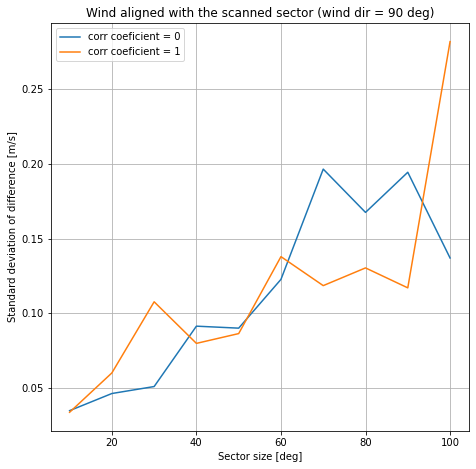

In [25]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.grid()


ds_IVAP_unc.unc_ws.sel(wind_direction=90,statistics='std', corr_coef=0).plot(ax=ax, label='corr coeficient = 0')
ds_IVAP_unc.unc_ws.sel(wind_direction=90,statistics='std', corr_coef=1).plot(ax=ax, label='corr coeficient = 1')

plt.xlabel('Sector size [deg]')
plt.ylabel('Standard deviation of difference [m/s]')

plt.title('Wind aligned with the scanned sector (wind dir = 90 deg)')
plt.legend(loc="upper left")
plt.show()

fig.savefig('./assets/std_diff_wind_speed_dir_90.png')

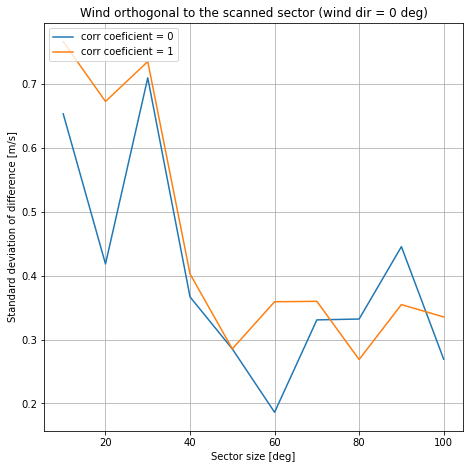

In [28]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.grid()


ds_IVAP_unc.unc_ws.sel(wind_direction=0,statistics='std', corr_coef=0).plot(ax=ax, label='corr coeficient = 0')
ds_IVAP_unc.unc_ws.sel(wind_direction=0,statistics='std', corr_coef=1).plot(ax=ax, label='corr coeficient = 1')

plt.xlabel('Sector size [deg]')
plt.ylabel('Standard deviation of difference [m/s]')

plt.title('Wind orthogonal to the scanned sector (wind dir = 0 deg)')
plt.legend(loc="upper left")
plt.show()

fig.savefig('./assets/std_diff_wind_speed_dir_0.png')

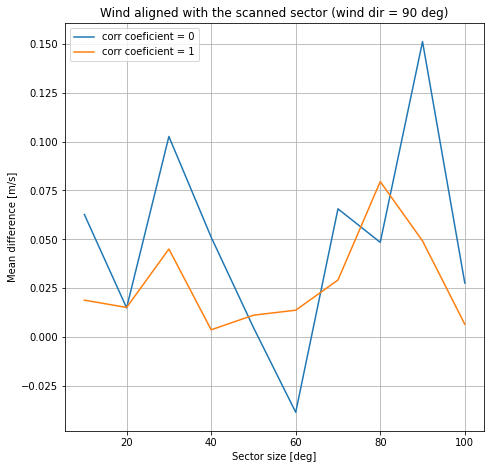

In [30]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.grid()


ds_IVAP_unc.unc_ws.sel(wind_direction=90,statistics='mean', corr_coef=0).plot(ax=ax, label='corr coeficient = 0')
ds_IVAP_unc.unc_ws.sel(wind_direction=90,statistics='mean', corr_coef=1).plot(ax=ax, label='corr coeficient = 1')

plt.xlabel('Sector size [deg]')
plt.ylabel('Mean difference [m/s]')

plt.title('Wind aligned with the scanned sector (wind dir = 90 deg)')
plt.legend(loc="upper left")
plt.show()

fig.savefig('./assets/mean_diff_wind_speed_dir_90.png')

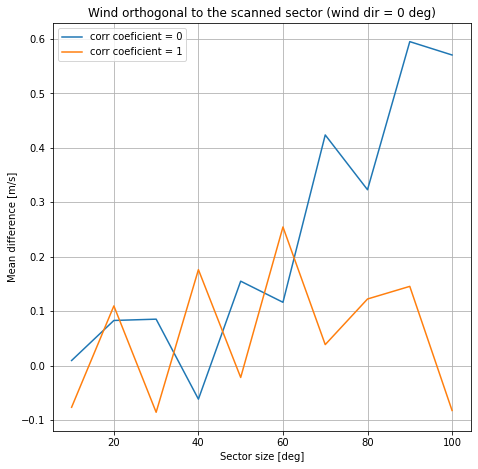

In [31]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
plt.grid()


ds_IVAP_unc.unc_ws.sel(wind_direction=0,statistics='mean', corr_coef=0).plot(ax=ax, label='corr coeficient = 0')
ds_IVAP_unc.unc_ws.sel(wind_direction=0,statistics='mean', corr_coef=1).plot(ax=ax, label='corr coeficient = 1')

plt.xlabel('Sector size [deg]')
plt.ylabel('Mean difference [m/s]')

plt.title('Wind orthogonal to the scanned sector (wind dir = 0 deg)')
plt.legend(loc="upper left")
plt.show()

fig.savefig('./assets/mean_diff_wind_speed_dir_0.png')